# Lab 2-3

## Demo

In [4]:
!ipc/ipc-static

ipc-static [-Bqsv] [-b buffersize] [-i pipe|local|tcp] [-p tcp_port]
	[-P l1d|l1i|l2|mem|tlb|axi] [-t totalsize] mode

Modes (pick one - default 1thread):
    1thread                IPC within a single thread
    2thread                IPC between two threads in one process
    2proc                  IPC between two threads in two different processes

Optional flags:
    -B                     Run in bare mode: no preparatory activities
    -i pipe|local|tcp      Select pipe, local sockets, or TCP (default: pipe)
    -p tcp_port            Set TCP port number (default: 10141)
    -P l1d|l1i|l2|mem|tlb|axi  Enable hardware performance counters
    -q                     Just run the benchmark, don't print stuff out
    -s                     Set send/receive socket-buffer sizes to buffersize
    -v                     Provide a verbose benchmark description
    -b buffersize          Specify a buffer size (default: 131072)
    -t totalsize           Specify total I/O size (default: 1677

In [5]:
!ipc/ipc-static -i pipe 2thread
!ipc/ipc-static -i local 2thread

274948.53 KBytes/sec
135210.06 KBytes/sec


In [4]:
!ipc/ipc-static -i local -s -b 1024 2thread

1664.42 KBytes/sec


In [3]:
!ipc/ipc-static -v -i pipe  -b {2**14 * 1024} 2thread

Benchmark configuration:
  buffersize: 16777216
  totalsize: 16777216
  blockcount: 1
  mode: 2thread
  ipctype: pipe
  time: 10.166771167
1611.52 KBytes/sec


In [6]:
!ipc/ipc-static -q -B -i pipe 2thread

# setup external library

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


# all the functions are in lib/
from lib.test import *

def setup_dependencies():
    # This callback is needed to execute commands from the outside file in lib/
    def exec_cmd(cmd):
        out = !{cmd}
        return out

    set_exec_callback(exec_cmd)
    setup_kernel()
    
setup_dependencies()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Things to do
- [ ] instrument clock_gettime for the IPC loop
- [ ] it may be sensible to inspect quantize() results for both the execution time distributions of the system calls, and the amount of data returned by each
- [ ] investigate scheduling events using the sched provider ( on-cpu and off-cpu events)
- [ ] instrument sleep and wakeup
- [ ] take care about pid and tid
- [ ] probe effect: one simple way to approach the problem is to analyse the results of performance benchmarking with and without DTrace scripts running
- [ ] discard the first result
- [ ] read the FreeBSD Benchmarking Advice wiki
### questions to answer
- How does increasing IPC buffer size uniformly change performance across IPC models – and why?
- Explore the impact of the probe effect on your causal investigation; how has DTrace changed the behavior of the benchmark?


# Profile

In [2]:
!pwd

/data/lab2


## Overall performances

In [44]:
# IO performance varying the buffer size
ipc_trace_script = """

BEGIN {
    in_benchmark = 0;
    cstart = 0;
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}



syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    trace(timestamp - cstart);
    /*printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::exit:entry
/execname == "ipc-static"/
{
}

"""


do_2_threads:

create second thread
sender: clock_gettime at the beginning
receiver: clock_gettime at the end

In [30]:
# for manual tracing from terminal
from lib.test import *
setup_dependencies()

BUFFER_SIZES = buffers_up_to_16MB()
benchmark(
    flags="-i pipe -q",
    output_name="pipe.json",
    trials=1,
    buff_sizes=[BUFFER_SIZES[7]],
    dtrace_script=ipc_trace_script
)

('buffer size:', 131072, 'collected so far: ', 0)
values collected: 1


{'aggr_dict': defaultdict(int, {}),
 'buffer_sizes': [131072],
 'output': ['51822252'],
 'program_outputs': ['']}

In [17]:
#flags, trials, buff_sizes, dtrace_script,output_name="", quiet=False):
TRIALS = 10
BUFFER_SIZES = buffers_up_to_16MB()
modes = ["local", "local -s", "pipe"]

for mode in modes:
    benchmark(
        flags="-i {} -B -q".format(mode),
        output_name="{}.json".format(mode),
        trials=TRIALS,
        buff_sizes=BUFFER_SIZES,
        dtrace_script=ipc_trace_script
    )

('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 8)
('buffer size:', 4096, 'collected so far: ', 17)
('buffer size:', 8192, 'collected so far: ', 29)
('buffer size:', 16384, 'collected so far: ', 38)
('buffer size:', 32768, 'collected so far: ', 48)
('buffer size:', 65536, 'collected so far: ', 58)
('buffer size:', 131072, 'collected so far: ', 67)
('buffer size:', 262144, 'collected so far: ', 76)
('buffer size:', 524288, 'collected so far: ', 87)
('buffer size:', 1048576, 'collected so far: ', 99)
('buffer size:', 2097152, 'collected so far: ', 109)
('buffer size:', 4194304, 'collected so far: ', 119)
('buffer size:', 8388608, 'collected so far: ', 129)
('buffer size:', 16777216, 'collected so far: ', 139)
values collected: 150
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 8)
('buffer size:', 4096, 'collected so far: ', 17)
('buffer size:', 8192, 'collected so far: ', 29)
('buffer size:', 16384

In [2]:
def plot_standard_bandwith_dtrace(ax = None, save_name ="IPC_overall_comparison.png" ):
    TRIALS = 10
    modes = ["local", "local -s", "pipe"]
    for mode in modes:
        ax = plot_bandwith(
            input_data_file="{}.json".format(mode),
            label = mode,
            y_label="IPC Bandwith (KB/s)",
            x_label="Buffer size (KB)",
            trials=TRIALS,
            save_name = save_name if mode == modes[-1] else None,
            axis = ax,
            title="IPC bandwidth vs buffer size",
        )
    return ax



In [10]:
def beautify_graph(axis):
    plt.axvline(x=1024*8, color='c')
    plt.axvline(x=1024*32, color='c')
    plt.axvline(x=1024*64, color='c')
    plt.axvline(x=1024*256, color='c')
    axis.axvspan(0, 32768, alpha=0.15, color='g')
    axis.axvspan(32769, 262144, alpha=0.15, color='c')
    axis.axvspan(262144, 1024**2 *16, alpha=0.15, color='r')

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


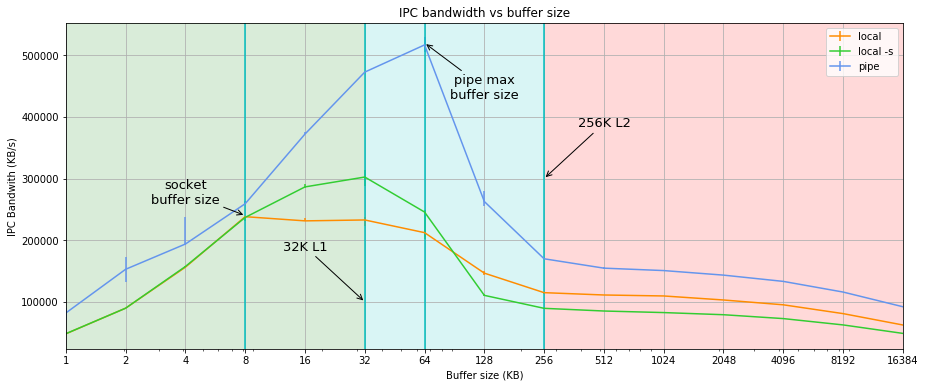

In [7]:
axis = plot_standard_bandwith_dtrace(None, None)


beautify_graph(axis)

y_arrow = 100000
y_text = y_arrow * 2
def kb(n): return n * 1024

axis.annotate('32K L1',
            xy=(kb(32),y_arrow), xycoords='data',
            xytext=(kb(16),y_text), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='center', verticalalignment='top', fontsize=13)

axis.annotate('256K L2',
            xy=(kb(256),y_arrow*3), xycoords='data',
            xytext=(kb(512),y_arrow*4), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='center', verticalalignment='top', fontsize=13)


axis.annotate('pipe max\nbuffer size',
            xy=(kb(64),y_arrow*5.2), xycoords='data',
            xytext=(kb(128),y_arrow*4.7), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='center', verticalalignment='top', fontsize=13)

axis.annotate('socket max\nbuffer size',
            xy=(kb(8),y_arrow*2.4), xycoords='data',
            xytext=(kb(4),y_arrow*3), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='center', verticalalignment='top', fontsize=13)

plt.savefig("IPC_overall_with_bars_w_text.png")


xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


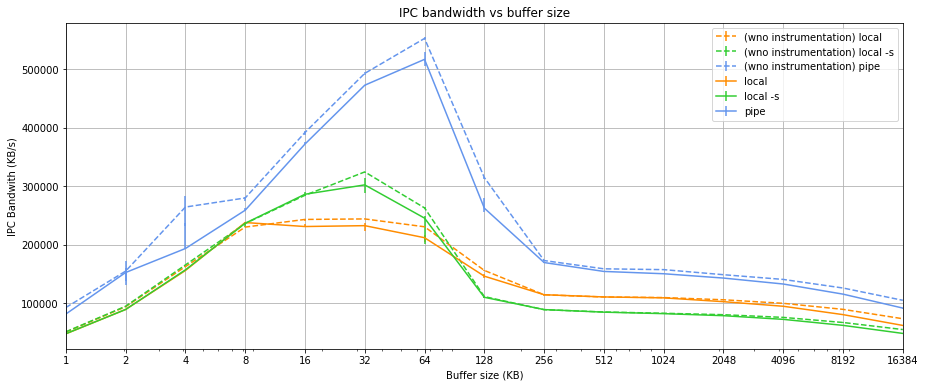

In [38]:
ax = plot_base(None,"plot_base_dtrace_comparison.png",dotted=True)
plot_standard_bandwith_dtrace(ax, "IPC_comparison_with_and_wno_dtrace.png")


In [22]:
 with open("pipe.json", 'r') as f:
        content = f.read()
        data = json.loads(content)
        print data

{u'buffer_sizes': [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216], u'aggr_dict': {}, u'output': [u'48745753787', u'48880709643', u'49059915069', u'49226526558', u'49350888373', u'49505856083', u'49630276948', u'49809989829', u'49976806052', u'50143725380', u'50248995568', u'50378291149', u'50497426895', u'50613113086', u'50735546620', u'50859888837', u'50981846354', u'51112582754', u'51235032269', u'51362245190', u'51468681521', u'51562628803', u'51661043526', u'51764459981', u'51867629718', u'51965071042', u'52065683587', u'52162935370', u'52261761847', u'52364939152', u'52470785750', u'52582753428', u'52689250478', u'52796190536', u'52901343792', u'53007982310', u'53114952525', u'53223621933', u'53331047381', u'53437233302', u'53534245427', u'53636029009', u'53732979258', u'53830867885', u'53932788086', u'54030032500', u'54126760308', u'54223328293', u'54320142213', u'54417262258', u'54510628503', u'54608086040', u'5

## Syscall read and write distribution

In [23]:
# IO performance varying the buffer size
syscall_distribution = """

BEGIN {
    in_benchmark = 0;
    cstart = 0;
}


syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}



syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    /* trace(timestamp - cstart);
   printf("tid: %d, pid: %d, time: %d", tid, pid, vtimestamp - self->cstart);*/
}

syscall::read:return 
/execname == "ipc-static" && in_benchmark > 0/
{
    @read = quantize(arg0);
    @tot_r = sum(arg0);
}

syscall::write:return 
/execname == "ipc-static"  && in_benchmark > 0/
{
    @write = quantize(arg0);
    @tot_w = sum(arg0);
}

syscall::exit:entry
/execname == "ipc-static" && in_benchmark <= 0/
{
    printf("pid: %d", pid);
    printf("Read aggregation:");
    printa(@read);
    printf("write aggregation:"); 
    printa(@write);
    
    printf("total read, write:");
    printa(@tot_r); printa(@tot_w);
    
    clear(@tot_r); clear(@tot_w);
    clear(@read); clear(@write);
    printf("##################################"); 
    in_benchmark = 0;

}

END
{
    exit(0);
}
"""
## pipes
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
print "\n".join(benchmark(
    flags="-i pipe -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)['output'])


kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 13)
('buffer size:', 4096, 'collected so far: ', 26)
('buffer size:', 8192, 'collected so far: ', 39)
('buffer size:', 16384, 'collected so far: ', 52)
('buffer size:', 32768, 'collected so far: ', 65)
('buffer size:', 65536, 'collected so far: ', 78)
('buffer size:', 131072, 'collected so far: ', 91)
('buffer size:', 262144, 'collected so far: ', 104)
('buffer size:', 524288, 'collected so far: ', 117)
('buffer size:', 1048576, 'collected so far: ', 130)
('buffer size:', 2097152, 'collected so far: ', 139)
('buffer size:', 4194304, 'collected so far: ', 152)
('buffer size:', 8388608, 'collected so far: ', 165)
('buffer size:', 16777216, 'collected so far: ', 178)
('values collected:', 189)
pid: 3826
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
          

In [24]:
# sockets distribution
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
print "\n".join(benchmark(
    flags="-i local -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)['output'])


kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 13)
('buffer size:', 4096, 'collected so far: ', 26)
('buffer size:', 8192, 'collected so far: ', 39)
('buffer size:', 16384, 'collected so far: ', 52)
('buffer size:', 32768, 'collected so far: ', 65)
('buffer size:', 65536, 'collected so far: ', 78)
('buffer size:', 131072, 'collected so far: ', 91)
('buffer size:', 262144, 'collected so far: ', 104)
('buffer size:', 524288, 'collected so far: ', 117)
('buffer size:', 1048576, 'collected so far: ', 130)
('buffer size:', 2097152, 'collected so far: ', 143)
('buffer size:', 4194304, 'collected so far: ', 156)
('buffer size:', 8388608, 'collected so far: ', 169)
('buffer size:', 16777216, 'collected so far: ', 182)
('values collected:', 195)
pid: 3917
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
          

In [25]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
print "\n".join(benchmark(
    flags="-i local -s -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)['output'])


kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 13)
('buffer size:', 4096, 'collected so far: ', 26)
('buffer size:', 8192, 'collected so far: ', 39)
('buffer size:', 16384, 'collected so far: ', 52)
('buffer size:', 32768, 'collected so far: ', 65)
('buffer size:', 65536, 'collected so far: ', 78)
('buffer size:', 131072, 'collected so far: ', 91)
('buffer size:', 262144, 'collected so far: ', 104)
('buffer size:', 524288, 'collected so far: ', 117)
('buffer size:', 1048576, 'collected so far: ', 130)
('buffer size:', 2097152, 'collected so far: ', 143)
('buffer size:', 4194304, 'collected so far: ', 156)
('buffer size:', 8388608, 'collected so far: ', 169)
('buffer size:', 16777216, 'collected so far: ', 182)
('values collected:', 195)
pid: 3950
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
          

In [11]:
## dummy, to trace from the command line
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]

benchmark(
    flags="-i pipe -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script="BEGIN { printf(\"t\");}"
)

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 1)
('buffer size:', 2048, 'collected so far: ', 1)
('buffer size:', 4096, 'collected so far: ', 1)
('buffer size:', 8192, 'collected so far: ', 1)
('buffer size:', 16384, 'collected so far: ', 1)
('buffer size:', 32768, 'collected so far: ', 1)
('buffer size:', 65536, 'collected so far: ', 1)
('buffer size:', 131072, 'collected so far: ', 1)
('buffer size:', 262144, 'collected so far: ', 1)
('buffer size:', 524288, 'collected so far: ', 1)
('buffer size:', 1048576, 'collected so far: ', 1)
('buffer size:', 2097152, 'collected so far: ', 1)
('buffer size:', 4194304, 'collected so far: ', 1)
('buffer size:', 8388608, 'collected so far: ', 1)
('buffer size:', 16777216, 'collected so far: ', 1)
('values collected:', 1)


{'aggr_dict': defaultdict(int, {}),
 'buffer_sizes': [1024,
  2048,
  4096,
  8192,
  16384,
  32768,
  65536,
  131072,
  262144,
  524288,
  1048576,
  2097152,
  4194304,
  8388608,
  16777216],
 'output': ['t'],
 'program_outputs': ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '']}

In [4]:
out, dic = benchmark(
    flags="-i local -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 42)
('buffer size:', 262144, 'collected so far: ', 42)
('buffer size:', 524288, 'collected so far: ', 42)
('buffer size:', 1048576, 'collected so far: ', 42)
('buffer size:', 2097152, 'collected so far: ', 70)
('buffer size:', 4194304, 'collected so far: ', 70)
('buffer size:', 8388608, 'collected so far: ', 70)
('buffer size:', 16777216, 'collected so far: ', 91)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [35]:
out, dic = benchmark(
    flags="-i local -s -q",
    trials=1,
    buff_sizes=BUFFER_SIZES,
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 14)
('buffer size:', 16384, 'collected so far: ', 14)
('buffer size:', 32768, 'collected so far: ', 14)
('buffer size:', 65536, 'collected so far: ', 14)
('buffer size:', 131072, 'collected so far: ', 42)
('buffer size:', 262144, 'collected so far: ', 42)
('buffer size:', 524288, 'collected so far: ', 42)
('buffer size:', 1048576, 'collected so far: ', 63)
('buffer size:', 2097152, 'collected so far: ', 63)
('buffer size:', 4194304, 'collected so far: ', 63)
('buffer size:', 8388608, 'collected so far: ', 84)
('buffer size:', 16777216, 'collected so far: ', 84)
('values collected:', 105)
Read aggregation:
value  ------------- Distribution ------------- count    
             512 |                                         0        
            1024 |@@@@@@@@@@@

In [34]:
out, dic = benchmark(
    flags="-i local -s -q",
    trials=1,
    buff_sizes=[BUFFER_SIZES[-1]],
    dtrace_script=syscall_distribution
)
print("\n".join(out))

kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 16777216, 'collected so far: ', 0)
('values collected:', 7)
Read aggregation:
value  ------------- Distribution ------------- count    
         8388608 |                                         0        
        16777216 |@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1        
        33554432 |                                         0

write aggregation:
value  ------------- Distribution ------------- count    
         8388608 |                                         0        
        16777216 |@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1        
        33554432 |                                         0

##################################


## traps

In [9]:
traps_script = """
BEGIN {
    in_benchmark = 0;
    cstart = 0;
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

fbt::abort_handler:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    @cnt = count();
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    printa(@cnt);   
}

"""

In [49]:
from lib.test import *
setup_dependencies()


BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
TRIALS = 10
modes = ["local","local -s", "pipe"]

for mode in modes:
    print "---> mode: ",mode
    res = benchmark_single_output_aggregation(
        flags="-i {} -q".format(mode),
        trials=TRIALS,
        output_name="traps_{}.json".format(mode),
        buff_sizes=BUFFER_SIZES,
        dtrace_script=traps_script
    )


---> mode:  local
benchmark single output aggregation with flags: -i local -q
benchmarking buffer size: 1024
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 1
!!! error, new lines in benchmark are not 2

('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 1
!!! error, new lines in benchmark are not 2

('buffer size:', 1024, 'collected so far: ', 0)
values collected: 1
!!! error, new lines in benchmark are not 2

('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 1
!!! error, new lines in benchmark are not 2

('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('bu

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


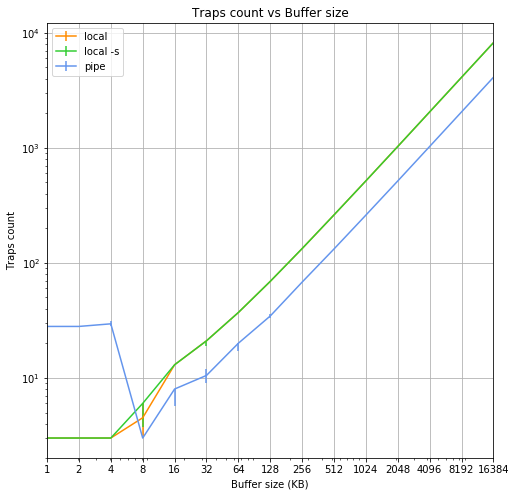

In [9]:
from lib.test import *
setup_dependencies()


BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
TRIALS = 10
modes = ["local","local -s", "pipe"]
ax = None
for mode in modes:
    ax = plot_aggregation(
        input_data_file="traps_{}.json".format(mode),
        label = mode,
        y_label="Traps count",
        x_label="Buffer size (KB)",
        trials=TRIALS,
        axis = ax,
        figsize=(8,8),
        title="Traps count vs Buffer size",
        save_name = "traps_overall_10_trials_squared.png" if mode == modes[-1] else None,
    )
    ax.set_yscale('log')

# VM faults

In [1]:
vm_fault_script = """
BEGIN {
    in_benchmark = 0;
    cstart = 0;
    @cnt = count();
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

fbt::vm_fault:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    @cnt = count()
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    printa(@cnt);   
}

"""

In [4]:
## todo: execute this again with trial size of 10
from lib.test import *
setup_dependencies()

BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
TRIALS = 10
modes = ["local","local -s", "pipe"]

for mode in modes:
    print "---> mode: ",mode
    res = benchmark_single_output_aggregation(
        flags="-i {} -B -q".format(mode),
        trials=TRIALS,
        output_name="vm_fault_{}.json".format(mode),
        buff_sizes=BUFFER_SIZES,
        dtrace_script=vm_fault_script
    )



---> mode:  local
benchmark single output aggregation with flags: -i local -B -q
benchmarking buffer size: 1024
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
benchmarking buffe

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


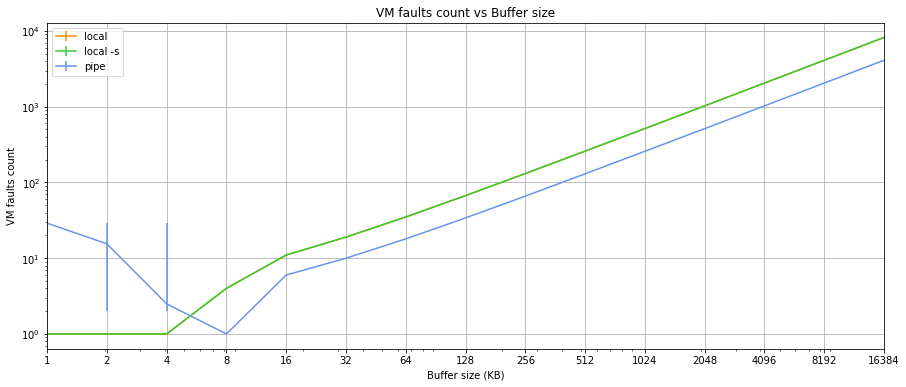

In [5]:
ax = None
for mode in modes:
    ax = plot_aggregation(
        input_data_file="vm_fault_{}.json".format(mode),
        label = mode,
        y_label="VM faults count",
        x_label="Buffer size (KB)",
        trials=TRIALS,
        axis = ax,
        title="VM faults count vs Buffer size",
        save_name = "vm_faults.png" if mode == modes[-1] else None,
    )
    ax.set_yscale('log')

In [12]:
vm_fault_time_script = """
BEGIN {
    in_benchmark = 0;
    cstart = 0;
    @time = sum(0);
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

fbt::vm_fault:entry
/execname == "ipc-static" && in_benchmark > 0/
{
        self->ts = vtimestamp;
}

fbt::vm_fault:return
/execname == "ipc-static"
        && self->ts
        && in_benchmark > 0/
{
        @time = sum(vtimestamp - self->ts);
}


syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    printa(@time);   
}

"""

In [14]:
from lib.test import *
setup_dependencies()

BUFFER_SIZES = [1024 * 2 ** exp for exp in range(1,15)]
TRIALS = 10
modes = ["local","local -s", "pipe"]

for mode in modes:
    print "---> mode: ",mode
    res = benchmark_single_output_aggregation(
        flags="-i {} -B -q".format(mode),
        trials=TRIALS,
        output_name="vm_fault_time_{}.json".format(mode),
        buff_sizes=BUFFER_SIZES,
        dtrace_script=vm_fault_time_script
    )



---> mode:  local
benchmark single output aggregation with flags: -i local -B -q
benchmarking buffer size: 2048
('buffer size:', 2048, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 2048, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 2048, 'collected so far: ', 0)
^C
values collected: 0
!!! error, new lines in benchmark are not 2

('buffer size:', 2048, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 2048, 'collected so far: ', 0)



KeyboardInterrupt


xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


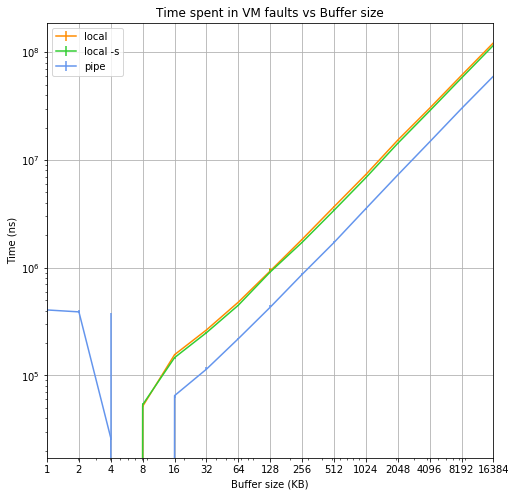

In [10]:
ax = None
for mode in modes:
    ax = plot_aggregation(
        input_data_file="vm_fault_time_{}.json".format(mode),
        label = mode,
        y_label="Time (ns)",
        x_label="Buffer size (KB)",
        trials=TRIALS,
        axis = ax,
        figsize=(8,8),
        title="Time spent in VM faults vs Buffer size",
        save_name = "vm_faults_time_squared.png" if mode == modes[-1] else None,
    )
    ax.set_yscale('log')

# Locks

In [66]:
spin_lock_script = """
BEGIN {
    in_benchmark = 0;
    cstart = 0;
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

lockstat:::thread-spin
/execname == "ipc-static" &&   in_benchmark > 0/
{
    @cnt = count()
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    printa(@cnt);   
}
"""

## todo the rest

## off-cpu time

In [50]:
# Scheduler activation
off_cpu_script = """

BEGIN {
    in_benchmark = 0;
    cstart = 0;
}

syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

sched:::off-cpu
/execname == "ipc-static" && in_benchmark > 0/
{
    /*printf("off-cpu tid: %d, pid: %d", tid, pid);*/
    off_cpu = timestamp;
}

sched:::on-cpu
/execname == "ipc-static" && in_benchmark > 0 && off_cpu/
{
  /*  printf("onn-cpu tid: %d, pid: %d, delay: %d", tid, pid, timestamp - off_cpu);*/
    @off_cpu_aggr = sum(timestamp - off_cpu);
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    printa(@off_cpu_aggr);   
  /*  printf("%d",timestamp-cstart);*/
}

"""




In [51]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
modes = ["local","local -s", "pipe"]
TRIALS = 10
for mode in modes:
    res = benchmark_single_output_aggregation(
        flags="-i {} -B -q".format(mode),
        trials=TRIALS,
        output_name="off_cpu_times_{}.json".format(mode),
        buff_sizes=BUFFER_SIZES,
        dtrace_script=off_cpu_script
    )

benchmark single output aggregation with flags: -i local -B -q
benchmarking buffer size: 1024
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
('buffer size:', 1024, 'collected so far: ', 0)
values collected: 2
2 new output lines
benchmarking buffer size: 2048
('buf

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


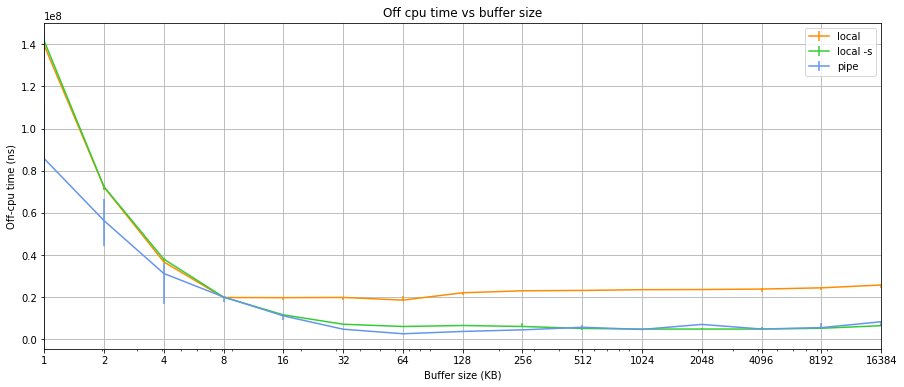

In [54]:
ax = None
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
modes = ["local","local -s", "pipe"]
TRIALS = 10
for mode in modes:
    ax = plot_aggregation(
        input_data_file="off_cpu_times_{}.json".format(mode),
        label = mode,
        y_label = "Off-cpu time (ns)",
        x_label = "Buffer size (KB)",
        trials=TRIALS,
        axis = ax,
        title = "Off cpu time vs buffer size", 
        save_name = "off_cpu_time_all.png" if mode == modes[-1] else None,
    )


## cpu scheduling graph

['100714 0 262', '100109 294 801', '100714 834 984', '100109 1001 1506', '100714 1534 34', '100109 48 370', '100714 391 420', '100109 432 718', '100714 740 27', '100109 38 311']


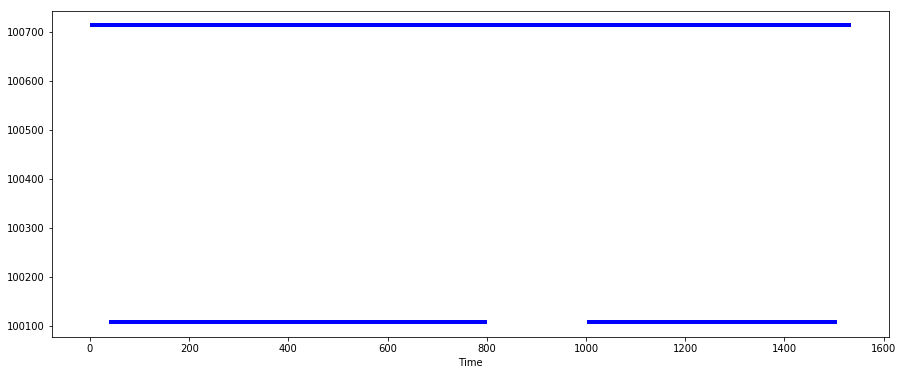

In [69]:

"""
# data format:
data = [
    "1 0 10",
    "2 5 15",
    "1 11 16"
]
"""
def plot_scheduling(to_plot):
    print to_plot
    plt.close()
    plt.clf()
    plt.figure(figsize=(15,6))
    y = [int(x.split(" ")[0]) for x in to_plot]
    start = [int(x.split(" ")[1]) for x in to_plot]
    stops = [int(x.split(" ")[2]) for x in to_plot]

    #Plot function
    def timelines(y, xstart, xstop, color='b'):
        """Plot timelines at y from xstart to xstop with given color."""   
        plt.hlines(y, xstart, xstop, color, lw=4)

    #Plot ok tl black    
    timelines(y, start, stops)

    plt.xlabel('Time')
    plt.show()
    
plot_scheduling( ['100714 0 262', '100109 294 801', '100714 834 984', '100109 1001 1506', '100714 1534 34', '100109 48 370', '100714 391 420', '100109 432 718', '100714 740 27', '100109 38 311'])

In [20]:
cpu_scheduling = """

BEGIN {
    in_benchmark = 0;
    cstart = 0;
    write_finished = 0;
}


syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

syscall::write:entry
/execname == "ipc-static" && in_benchmark > 0 && write_finished == 0/
{
   printf("read thread: %d",tid);
   write_start = timestamp;
   in_write = 1;
}
syscall::write:return
/execname == "ipc-static" && in_benchmark > 0/
{
   write_finished = 1;
   in_write = 0;
}
sched:::on-cpu
/execname == "ipc-static" && in_benchmark > 0 && in_write/
{
   self->start_on_cpu = timestamp - write_start;
}

sched:::off-cpu
/execname == "ipc-static" && in_benchmark > 0 && in_write/
{
   printf("%d %d %d", tid, self->start_on_cpu/1000, (timestamp - write_start)/1000);
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
}
"""

('buffer size:', 524288, 'collected so far: ', 0)
('values collected:', 17)
read thread: 100728
['100728 0 283', '100109 319 785', '100728 817 1004', '100109 1024 1453', '100728 1485 1670', '100109 1688 2116', '100728 2142 2301', '100109 2318 2786', '100728 2812 2981', '100109 3000 3472', '100728 3501 3688', '100109 3709 4129', '100728 4159 4329', '100109 4348 4811', '100728 4839 5007', '100109 5024 5498']
['100728 0 283', '100109 319 785', '100728 817 1004', '100109 1024 1453', '100728 1485 1670', '100109 1688 2116', '100728 2142 2301', '100109 2318 2786', '100728 2812 2981', '100109 3000 3472', '100728 3501 3688', '100109 3709 4129', '100728 4159 4329', '100109 4348 4811', '100728 4839 5007', '100109 5024 5498']


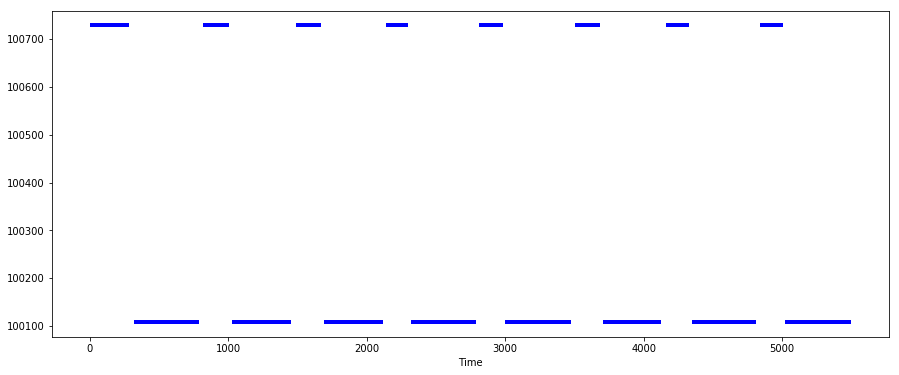

In [76]:

res = benchmark(
                flags="-i pipe -q",
                trials=1,
                buff_sizes=[BUFFER_SIZES[9]],
                dtrace_script=cpu_scheduling
            )
print res["output"][0]
data = res["output"][1:]
print data
plot_scheduling(data)

# Sleep time

In [49]:

sleep_part = """
#pragma D option flowindent

BEGIN {
    in_benchmark = 0;
    cstart = 0;
}


syscall::clock_gettime:return
/execname == "ipc-static" && in_benchmark <= 0/
{
    in_benchmark++;
    cstart = in_benchmark == 1 ? timestamp : cstart;
}

syscall::write:entry
/execname == "ipc-static" && in_benchmark > 0/
{
   in_write = 1;
}
syscall::write:return
/execname == "ipc-static" && in_benchmark > 0/
{
   in_write = 0;
}

sched:::sleep
/execname == "ipc-static" && in_write/
{
   sleep_t = timestamp;
}

sched:::wakeup
/execname == "ipc-static" && in_write/ 
{
   @sleep_time = sum(timestamp-sleep_t);
}

syscall::clock_gettime:entry
/execname == "ipc-static" && in_benchmark > 0/
{
    in_benchmark = -1;
    printa(@sleep_time);
}

"""

In [20]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]

res = benchmark(
                flags="-i pipe -q",
                trials=1,
                buff_sizes=[BUFFER_SIZES[10]],
                dtrace_script=sleep_part,
                quiet=True
            )
print "\n".join(res["output"])


6126253232200



In [25]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0,15)]
modes = ["local","local -s", "pipe"]
TRIALS = 5
## TODO: execute each benchmark trials times, and plot the first value of output (which is the time where no threads were executing)
sleep_times = {}
for mode in modes:
    print "Starting mode {}".format(mode)
    sleep_times[mode] = []
    for sz in BUFFER_SIZES:
        print "### Starting buffer size {}".format(sz)

        for t in range(TRIALS):
            res = benchmark(
                flags="-i {} -q".format(mode),
                trials=1,
                buff_sizes=[sz],
                quiet=True,
                dtrace_script=sleep_part
            )
            try:
                sleep_times[mode].append(int(res["output"][0]))
            except:
                print "---------------->problem with output: {}".format("\n".join(res["output"]))
                print(res)
                sleep_times[mode].append(0)
        print "### values len: {}".format(len(sleep_times[mode]))
    

Starting mode local
### Starting buffer size 1024
### values len: 5
### Starting buffer size 2048
### values len: 10
### Starting buffer size 4096
### values len: 15
### Starting buffer size 8192
### values len: 20
### Starting buffer size 16384
### values len: 25
### Starting buffer size 32768
### values len: 30
### Starting buffer size 65536
### values len: 35
### Starting buffer size 131072
### values len: 40
### Starting buffer size 262144
### values len: 45
### Starting buffer size 524288
### values len: 50
### Starting buffer size 1048576
### values len: 55
### Starting buffer size 2097152
### values len: 60
### Starting buffer size 4194304
### values len: 65
### Starting buffer size 8388608
### values len: 70
### Starting buffer size 16777216
### values len: 75
Starting mode local -s
### Starting buffer size 1024
### values len: 5
### Starting buffer size 2048
### values len: 10
### Starting buffer size 4096
### values len: 15
### Starting buffer size 8192
### values len: 20
###

In [26]:
print sleep_times

{'pipe': [7038501360395L, 7396648443378L, 7155266012134L, 7483926853032L, 7666867358430L, 6960864626553L, 7016542374116L, 7354735768800L, 6940268780951L, 7065385849628L, 7017115039814L, 6988049076918L, 6973909346459L, 7001604508102L, 6962471698036L, 6925431293855L, 6928903830924L, 6932426084093L, 6935899024254L, 74807063, 40366624, 6946582897069L, 42971895, 6953722341531L, 6957316915559L, 6960817370580L, 29828028, 31741194, 29835003, 39114394, 6978725744285L, 6982235714227L, 31367174, 6989369767170L, 6992916104311L, 6996553268673L, 7000106621881L, 56906479, 45200807, 7010804955926L, 93444280, 7017953287338L, 7021491077252L, 98430807, 7028571219500L, 7032078062643L, 102790209, 7039237681731L, 7042782293210L, 100163384, 7049929627984L, 7053478563347L, 109060055, 7060559594596L, 101841028, 7067772801111L, 7071314275300L, 7074845372172L, 7078393503970L, 7081952221847L, 7085553917409L, 7089115604696L, 7092625734089L, 109892564, 7099724703655L, 7103239421504L, 7106760054898L, 7110321491689L,

xvs len: 15 yvs len: 75 trials: 5
xvs len: 15 yvs len: 75 trials: 5
xvs len: 15 yvs len: 75 trials: 5


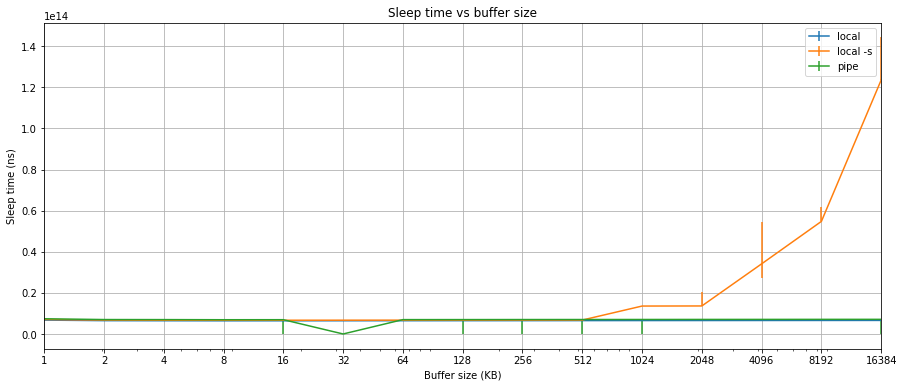

In [28]:
ax = plot_graph(BUFFER_SIZES, # x values
               sleep_times[modes[0]], # y values
               title = "Sleep time vs buffer size", 
               trials = TRIALS,
               label = modes[0],
               y_label = "Sleep time (ns)",
               x_label = "Buffer size (KB)"
)
plot_graph(BUFFER_SIZES, # x values
            sleep_times[modes[1]], # y values
            label = modes[1],
            trials = TRIALS,
            axis = ax
)

plot_graph(BUFFER_SIZES, # x values
            sleep_times[modes[2]], # y values
            label = modes[2],
            trials = TRIALS,
            save_name = "sleep_time_all.png", 
            axis = ax
)


## Lab 3

In [3]:
!ipc/ipc-static -i local -b 512 -P mem 1thread
!ipc/ipc-static -i local -b 512 -P l1d 1thread
!ipc/ipc-static -i local -b 512 -P l1i 1thread
!ipc/ipc-static -i local -b 512 -P l2 1thread
!ipc/ipc-static -i local -b 512 -P axi 1thread
!ipc/ipc-static -i local -b 512 -P tlb 1thread


  pmctype: mem
  INSTR_EXECUTED: 134545861
  CLOCK_CYCLES: 272402826
  CLOCK_CYCLES/INSTR_EXECUTED: 2.024610
  MEM_READ: 29640035
  MEM_READ/INSTR_EXECUTED: 0.220297
  MEM_READ/CLOCK_CYCLES: 0.108810
  MEM_WRITE: 16995753
  MEM_WRITE/INSTR_EXECUTED: 0.126319
  MEM_WRITE/CLOCK_CYCLES: 0.062392

49611.20 KBytes/sec

  pmctype: l1d
  INSTR_EXECUTED: 134543664
  CLOCK_CYCLES: 274847168
  CLOCK_CYCLES/INSTR_EXECUTED: 2.042810
  L1_DCACHE_ACCESS: 58381549
  L1_DCACHE_ACCESS/INSTR_EXECUTED: 0.433923
  L1_DCACHE_ACCESS/CLOCK_CYCLES: 0.212415
  L1_DCACHE_REFILL: 210774
  L1_DCACHE_REFILL/INSTR_EXECUTED: 0.001567
  L1_DCACHE_REFILL/CLOCK_CYCLES: 0.000767

49045.29 KBytes/sec

  pmctype: l1i
  INSTR_EXECUTED: 134546290
  CLOCK_CYCLES: 272474127
  CLOCK_CYCLES/INSTR_EXECUTED: 2.025133
  L1_ICACHE_REFILL: 2593182
  L1_ICACHE_REFILL/INSTR_EXECUTED: 0.019274
  L1_ICACHE_REFILL/CLOCK_CYCLES: 0.009517

51220.30 KBytes/sec

  pmctype: l2
  INSTR_EXECUTED: 134530304
  CLOCK_CYCLES: 272120395
  CLOCK_CYC

In [18]:
!ipc/ipc-static -i local -b 512 -P axil2 2thread -v

ipc-static [-Bqsv] [-b buffersize] [-i pipe|local|tcp] [-p tcp_port]
	[-P l1d|l1i|l2|mem|tlb|axi] [-t totalsize] mode

Modes (pick one - default 1thread):
    1thread                IPC within a single thread
    2thread                IPC between two threads in one process
    2proc                  IPC between two threads in two different processes

Optional flags:
    -B                     Run in bare mode: no preparatory activities
    -i pipe|local|tcp      Select pipe, local sockets, or TCP (default: pipe)
    -p tcp_port            Set TCP port number (default: 10141)
    -P l1d|l1i|l2|mem|tlb|axi  Enable hardware performance counters
    -q                     Just run the benchmark, don't print stuff out
    -s                     Set send/receive socket-buffer sizes to buffersize
    -v                     Provide a verbose benchmark description
    -b buffersize          Specify a buffer size (default: 131072)
    -t totalsize           Specify total I/O size (default: 1677

In [5]:
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]
dummy_dtrace_script = "BEGIN { printf(\"t\");}"
TRIALS = 10

modes = ["local","local -s", "pipe"]
pmcs = ["mem", "l1d", "l2","axi"]
additional_pmc = ["l1i","tlb"]

def generate_name(mode, pmc):
    return "pmc_{}_{}.json".format(pmc, mode.replace(" ","_"))

# plots the pmc for each mode (eg. socket, pipe, socket -s)
def plot_specific_pmc(pmc_group, pmc_value, y_label = None, x_label = None, title = None, figsize=(9,9),save_name = None,linestyle="-"):
    ax = None
    for mode in modes:
        file_name = generate_name(mode,pmc_group)
        ax = plot_pmc(
            input_data_file=file_name,
            pmc_to_plot=pmc_value,
            label = mode,
            y_label=y_label,
            x_label=x_label,
            trials=TRIALS,
            title=title,
            save_name = save_name if mode == modes[-1] else None,
            axis = ax,
            figsize=figsize,
            linestyle=linestyle
        )
    return ax

def gather_all_pmc_data(pmcs_to_gather = pmcs):
    for mode in modes:
        for pmc in pmcs_to_gather:

            flags = "-i {} -P {}".format(mode,pmc)
            out_name = generate_name(mode=mode, pmc=pmc)

            print "mode: ",mode, "pmc:",pmc, "flags:", flags, "out_name:",out_name

            res = benchmark(
                flags=flags,
                trials=TRIALS,
                output_name=out_name,
                buff_sizes=BUFFER_SIZES,
                dtrace_script=dummy_dtrace_script
            )
def gather_additional_pmc_data():
    gather_all_pmc_data(additional_pmc)


In [3]:
gather_all_pmc_data()

mode:  local pmc: mem flags: -i local -P mem out_name: pmc_mem_local.json
kern.ipc.maxsockbuf: 33554432 -> 33554432
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 1)
('buffer size:', 4096, 'collected so far: ', 1)
('buffer size:', 8192, 'collected so far: ', 1)
('buffer size:', 16384, 'collected so far: ', 1)
('buffer size:', 32768, 'collected so far: ', 1)
('buffer size:', 65536, 'collected so far: ', 1)
('buffer size:', 131072, 'collected so far: ', 1)
('buffer size:', 262144, 'collected so far: ', 1)
('buffer size:', 524288, 'collected so far: ', 1)
('buffer size:', 1048576, 'collected so far: ', 1)
('buffer size:', 2097152, 'collected so far: ', 1)
('buffer size:', 4194304, 'collected so far: ', 1)
('buffer size:', 8388608, 'collected so far: ', 1)
('buffer size:', 16777216, 'collected so far: ', 1)
('values collected:', 1)
mode:  local pmc: l1d flags: -i local -P l1d out_name: pmc_l1d_local.json
kern.ipc.maxsockbuf: 33554432 -> 3355443

In [7]:
gather_additional_pmc_data()

mode:  local pmc: l1i flags: -i local -P l1i out_name: pmc_l1i_local.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 1)
('buffer size:', 4096, 'collected so far: ', 1)
('buffer size:', 8192, 'collected so far: ', 1)
('buffer size:', 16384, 'collected so far: ', 1)
('buffer size:', 32768, 'collected so far: ', 1)
('buffer size:', 65536, 'collected so far: ', 1)
('buffer size:', 131072, 'collected so far: ', 1)
('buffer size:', 262144, 'collected so far: ', 1)
('buffer size:', 524288, 'collected so far: ', 1)
('buffer size:', 1048576, 'collected so far: ', 1)
('buffer size:', 2097152, 'collected so far: ', 1)
('buffer size:', 4194304, 'collected so far: ', 1)
('buffer size:', 8388608, 'collected so far: ', 1)
('buffer size:', 16777216, 'collected so far: ', 1)
values collected: 1
mode:  local pmc: tlb flags: -i local -P tlb out_name: pmc_tlb_local.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so fa

In [8]:
relevant_pmcs = [
    ("mem","INSTR_EXECUTED"),
    ("mem","CLOCK_CYCLES/INSTR_EXECUTED"),
    ("mem","MEM_READ"),
    ("mem", "MEM_WRITE"),
    ("mem","MEM_READ/INSTR_EXECUTED", ),
    ("mem","MEM_WRITE/INSTR_EXECUTED"),
    ("l1d","L1_DCACHE_ACCESS"),
    ("l1d","L1_DCACHE_REFILL"),
    ("l1i","L1_ICACHE_REFILL"),
    ("l2","L2_ACCESS"),
    ("axi","AXI_READ"),
    ("axi","AXI_WRITE"),
    ("tlb","DTLB_REFILL"),
]

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
graphs/pmc_INSTR_EXECUTED.png saved.
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
graphs/pmc_CLOCK_CYCLES_INSTR_EXECUTED.png saved.
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
graphs/pmc_MEM_READ.png saved.
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
graphs/pmc_MEM_WRITE.png saved.
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
graphs/pmc_MEM_READ_INSTR_EXECUTED.png saved.
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
graphs/pmc_MEM_WRITE_INSTR_EXECUTED.png saved.
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
g

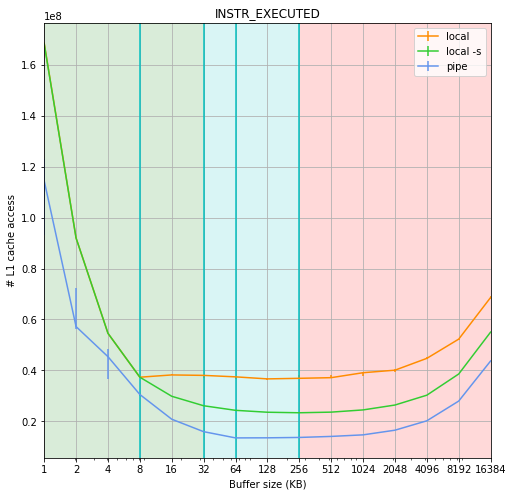

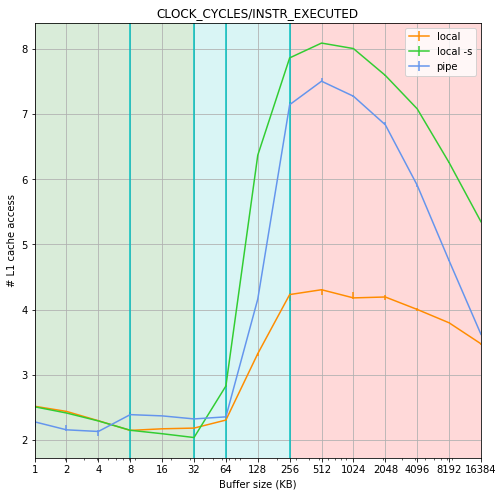

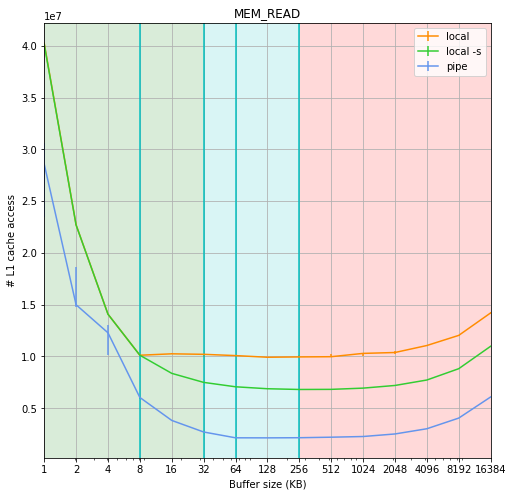

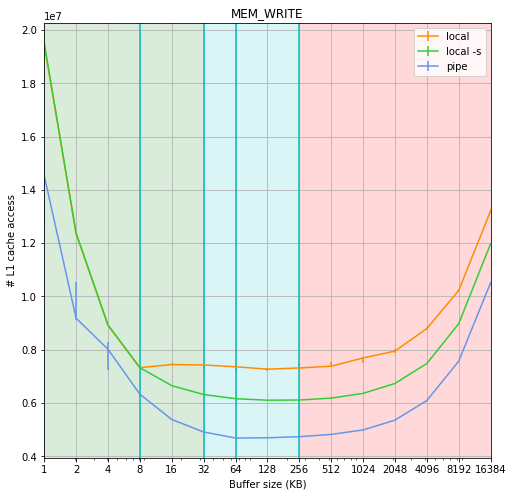

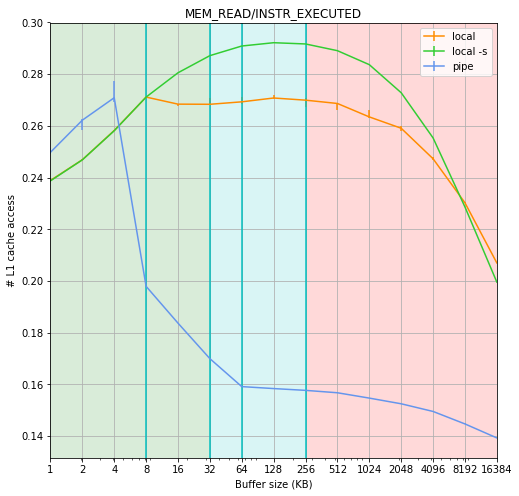

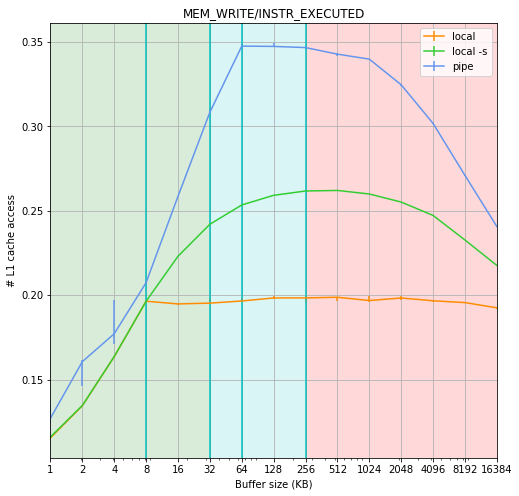

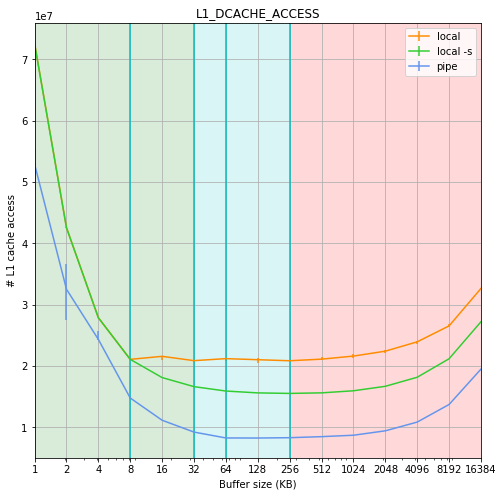

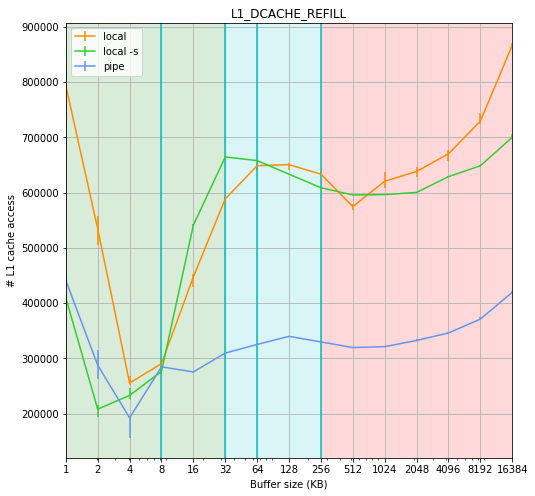

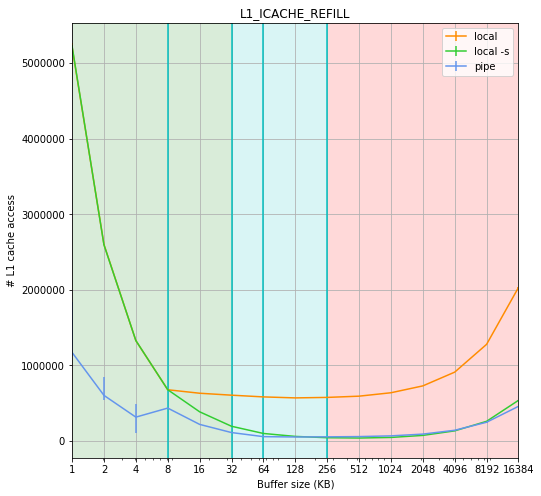

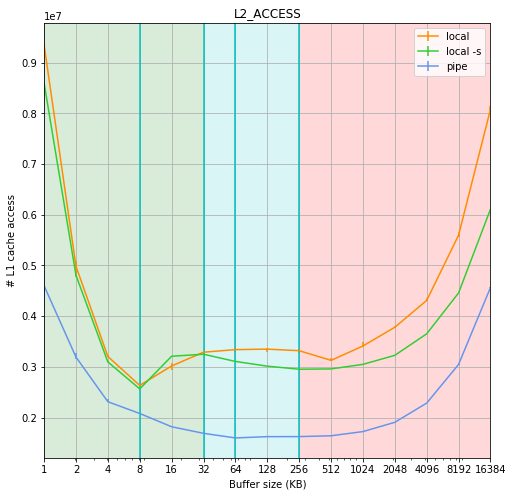

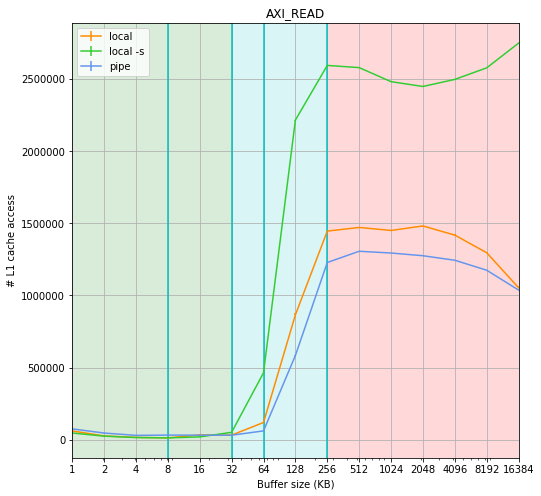

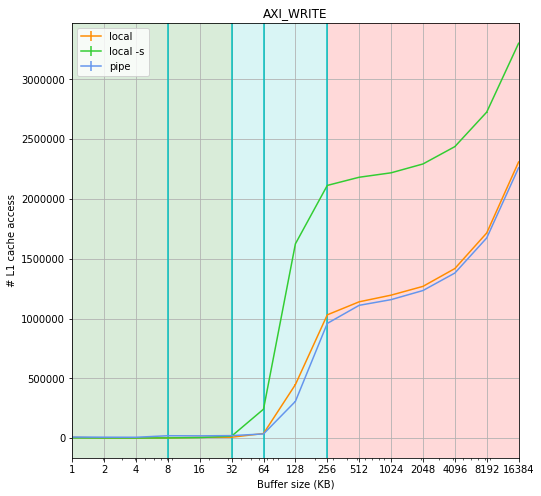

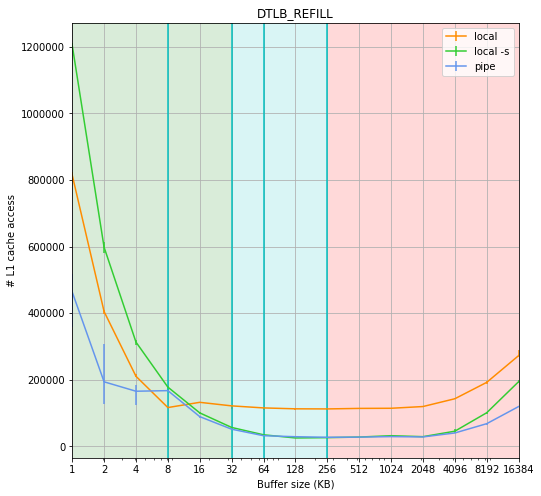

In [12]:
# plot all the relevant graphs
for r in relevant_pmcs:
    ax = plot_specific_pmc(r[0], r[1], 
                        y_label="# L1 cache access",
                        x_label="Buffer size (KB)",
                        title=r[1])
    beautify_graph(ax)
    save_name = "graphs/pmc_{}.png".format(r[1].replace("/","_"))
    plt.savefig(save_name)
    print "{} saved.".format(save_name)

In [51]:
# impact of dtrace on clock cycles/instruction
from lib.test import *
setup_dependencies()


BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]
TRIALS = 10

for mode in modes:
    flags = "-i {} -P mem".format(mode)
    out_name = "pmc_mem_while_tracing_sleep_{}.json".format(mode)

    print "mode: ",mode, "flags:", flags, "out_name:",out_name

    res = benchmark(
        flags=flags,
        trials=TRIALS,
        output_name=out_name,
        buff_sizes=BUFFER_SIZES,
        dtrace_script=sleep_part
    )


mode:  local flags: -i local -P mem out_name: pmc_mem_while_tracing_sleep_local.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 18)
('buffer size:', 4096, 'collected so far: ', 38)
('buffer size:', 8192, 'collected so far: ', 58)
('buffer size:', 16384, 'collected so far: ', 78)
('buffer size:', 32768, 'collected so far: ', 98)
('buffer size:', 65536, 'collected so far: ', 118)
('buffer size:', 131072, 'collected so far: ', 138)
('buffer size:', 262144, 'collected so far: ', 158)
('buffer size:', 524288, 'collected so far: ', 178)
('buffer size:', 1048576, 'collected so far: ', 198)
('buffer size:', 2097152, 'collected so far: ', 218)
('buffer size:', 4194304, 'collected so far: ', 238)
('buffer size:', 8388608, 'collected so far: ', 258)
('buffer size:', 16777216, 'collected so far: ', 278)
values collected: 300
mode:  local -s flags: -i local -s -P mem out_name: pmc_mem_while_tracing_sleep_local -s.json
('buffer size:', 1024, 'collect

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


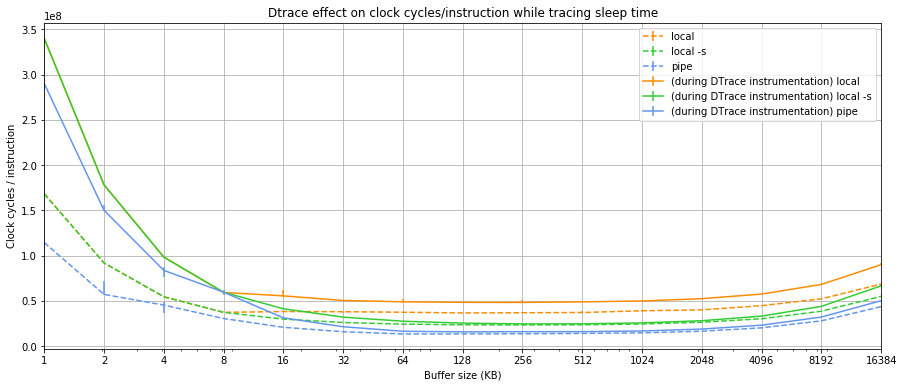

In [53]:
ax = plot_specific_pmc("mem", "INSTR_EXECUTED", 
                    y_label="Clock cycles / instruction",
                    x_label="Buffer size (KB)",
                    title="Clock cycles / instruction vs buffer size",
                  linestyle="--"
                    )
for mode in modes:
    file_name = "pmc_mem_while_tracing_sleep_{}.json".format(mode)
    ax = plot_pmc(
        input_data_file=file_name,
        pmc_to_plot="INSTR_EXECUTED",
        label = "(during DTrace instrumentation) "+mode,
        trials=TRIALS,
        title="Dtrace effect on clock cycles/instruction while tracing sleep time",
        axis = ax,
        save_name= "PMC_dtrace_impact_clock_instr.png" if mode == modes[-1] else None
    )


xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


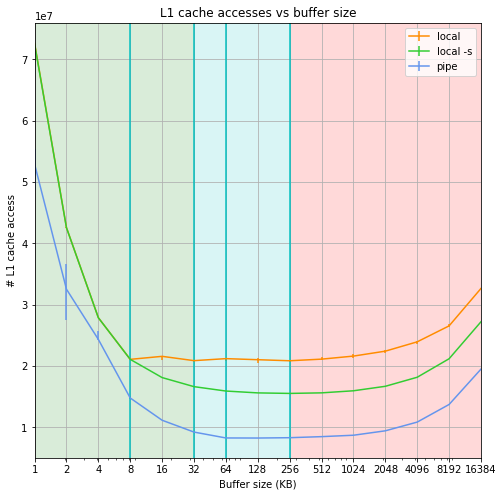

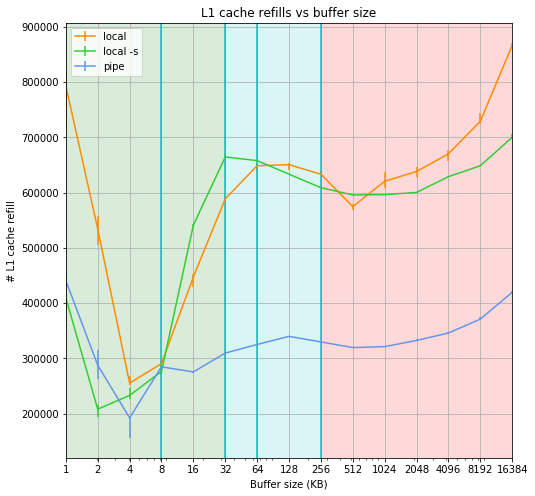

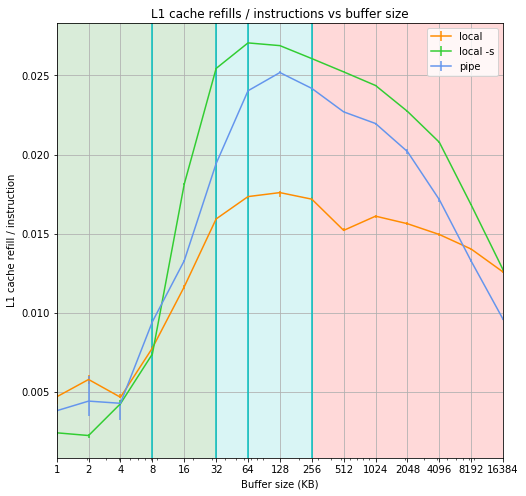

In [21]:
ax = plot_specific_pmc("l1d", "L1_DCACHE_ACCESS", 
                    y_label="# L1 cache access",
                    x_label="Buffer size (KB)",
                    title="L1 cache accesses vs buffer size",
                    save_name = "graphs/pmc_l1_access.png")
beautify_graph(ax)
ax = plot_specific_pmc("l1d", "L1_DCACHE_REFILL", 
                    y_label="# L1 cache refill",
                    x_label="Buffer size (KB)",
                    title="L1 cache refills vs buffer size",
                    save_name = "graphs/pmc_l1_refill.png")
beautify_graph(ax)

ax = plot_specific_pmc("l1d", "L1_DCACHE_REFILL/INSTR_EXECUTED", 
                    y_label="L1 cache refill / instruction",
                    x_label="Buffer size (KB)",
                    title="L1 cache refills / instructions vs buffer size",
                    save_name = "graphs/pmc_l1_refill_per_instr.png")
beautify_graph(ax)


xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


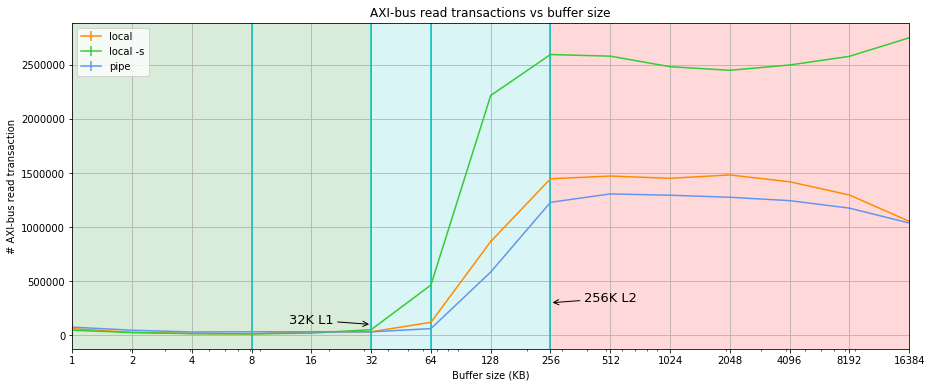

In [20]:

ax = plot_specific_pmc("axi", "AXI_READ", 
                    y_label="# AXI-bus read transaction",
                    x_label="Buffer size (KB)",
                    title="AXI-bus read transactions vs buffer size",
                    save_name = "graphs/pmc_axi_read.png",
                    figsize=(15,6))
beautify_graph(ax)
ax.annotate('32K L1',
            xy=(kb(32),y_arrow), xycoords='data',
            xytext=(kb(16),y_text), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='center', verticalalignment='top', fontsize=13)

ax.annotate('256K L2',
            xy=(kb(256),y_arrow*3), xycoords='data',
            xytext=(kb(512),y_arrow*4), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            horizontalalignment='center', verticalalignment='top', fontsize=13)

plt.savefig("graphs/pmc_axi_read.png")


In [ ]:
plot_specific_pmc("axi", "AXI_WRITE", 
                    y_label="# AXI-bus write transaction",
                    x_label="Buffer size (KB)",
                    title="AXI-bus write transactions vs buffer size",
                    save_name = "graphs/pmc_axi_write.png")

# Probe effect

In [5]:
# Impact of performance measurment with dtrace: here the benchmark runs without any active probe
# Then, we can compare the two graphs
setup_dependencies()
benchmark_without_dtrace(name_prefix="wno_dtrace")

mode:  local flags: -i local -v out_name: wno_dtrace_local.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 0)
('buffer size:', 16384, 'collected so far: ', 0)
('buffer size:', 32768, 'collected so far: ', 0)
('buffer size:', 65536, 'collected so far: ', 0)
('buffer size:', 131072, 'collected so far: ', 0)
('buffer size:', 262144, 'collected so far: ', 0)
('buffer size:', 524288, 'collected so far: ', 0)
('buffer size:', 1048576, 'collected so far: ', 0)
('buffer size:', 2097152, 'collected so far: ', 0)
('buffer size:', 4194304, 'collected so far: ', 0)
('buffer size:', 8388608, 'collected so far: ', 0)
('buffer size:', 16777216, 'collected so far: ', 0)
values collected: 0
mode:  local -s flags: -i local -s -v out_name: wno_dtrace_local -s.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('

In [36]:
setup_dependencies()

def plot_base(ax = None, save_name = "performance_wno_dtrace.png", dotted = False):
    modes = ["local", "local -s", "pipe"]
    for mode in modes:
        ax = plot_time(
            input_data_file="wno_dtrace_{}.json".format(mode),
            label = "(wno instrumentation) "+mode,
            y_label="IPC Bandwith (KB/s)",
            x_label="Buffer size (KB)",
            trials=10,
            axis = ax,
            dotted=dotted,
            title="Performance measurement without DTrace running",
            save_name = save_name if mode == modes[-1] else None,
        )
    return ax


xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


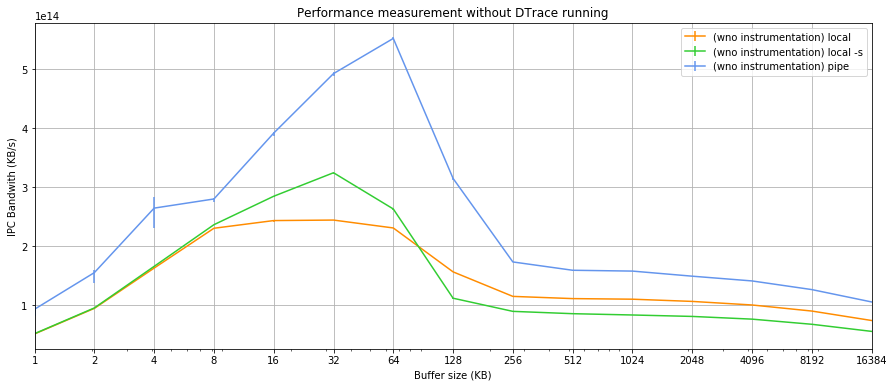

In [40]:
plot_base()

In [17]:
# Impact of tracing VM faults with dtrace over the baseline
setup_dependencies()
benchmark_without_dtrace(name_prefix="traps_overhead",script=traps_script)

mode:  local flags: -i local -v out_name: traps_overhead_local.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 14)
('buffer size:', 4096, 'collected so far: ', 27)
('buffer size:', 8192, 'collected so far: ', 42)
('buffer size:', 16384, 'collected so far: ', 62)
('buffer size:', 32768, 'collected so far: ', 82)
('buffer size:', 65536, 'collected so far: ', 102)
('buffer size:', 131072, 'collected so far: ', 122)
('buffer size:', 262144, 'collected so far: ', 142)
('buffer size:', 524288, 'collected so far: ', 162)
('buffer size:', 1048576, 'collected so far: ', 182)
('buffer size:', 2097152, 'collected so far: ', 202)
('buffer size:', 4194304, 'collected so far: ', 222)
('buffer size:', 8388608, 'collected so far: ', 242)
('buffer size:', 16777216, 'collected so far: ', 262)
values collected: 284
mode:  local -s flags: -i local -s -v out_name: traps_overhead_local -s.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


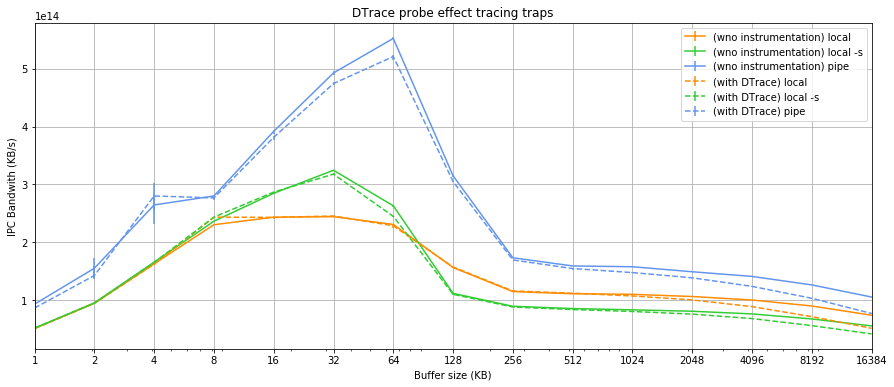

In [43]:
setup_dependencies()


modes = ["local", "local -s", "pipe"]
ax = plot_base()
for mode in modes:
    ax = plot_time(
        input_data_file="traps_overhead_{}.json".format(mode),
        label = "(with DTrace) "+mode,
        trials=10,
        axis = ax,
        title="DTrace probe effect tracing traps",
        save_name = "bandwith_during_trap_recording.png" if mode == modes[-1] else None,
    )


In [21]:
benchmark_without_dtrace(name_prefix="cpu_scheduling_overhead",script=cpu_scheduling)

mode:  local flags: -i local -v out_name: cpu_scheduling_overhead_local.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 1)
('buffer size:', 4096, 'collected so far: ', 1)
('buffer size:', 8192, 'collected so far: ', 1)
('buffer size:', 16384, 'collected so far: ', 1)
('buffer size:', 32768, 'collected so far: ', 1)
('buffer size:', 65536, 'collected so far: ', 1)
('buffer size:', 131072, 'collected so far: ', 1)
('buffer size:', 262144, 'collected so far: ', 1)
('buffer size:', 524288, 'collected so far: ', 1)
('buffer size:', 1048576, 'collected so far: ', 1)
('buffer size:', 2097152, 'collected so far: ', 1)
('buffer size:', 4194304, 'collected so far: ', 1)
('buffer size:', 8388608, 'collected so far: ', 1)
('buffer size:', 16777216, 'collected so far: ', 1)
values collected: 1
mode:  local -s flags: -i local -s -v out_name: cpu_scheduling_overhead_local -s.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, '

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


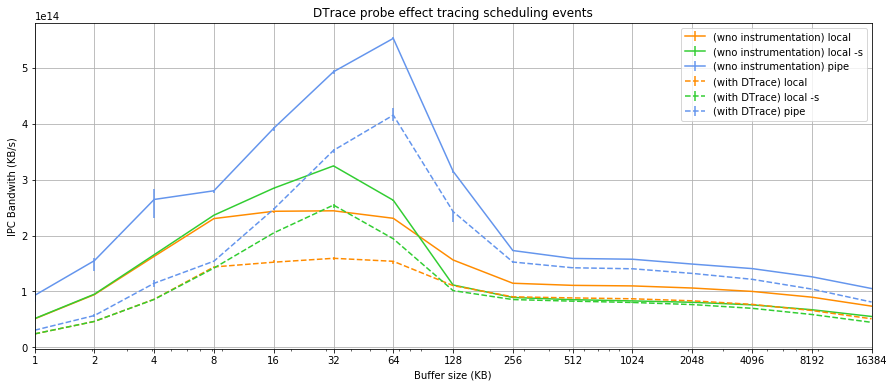

In [41]:
setup_dependencies()


modes = ["local", "local -s", "pipe"]
ax = plot_base()
for mode in modes:
    ax = plot_time(
        input_data_file="cpu_scheduling_overhead_{}.json".format(mode),
        label = "(with DTrace) "+mode,
        trials=10,
        axis = ax,
        title="DTrace probe effect tracing scheduling events",
        save_name = "bandwith_during_scheduling_recording.png" if mode == modes[-1] else None,
    )


In [46]:
setup_dependencies()
benchmark_without_dtrace("PMC_time_bench", additional_flags= "-P mem")

mode:  local flags: -i local -v -P mem out_name: PMC_time_bench_local-P mem.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 0)
('buffer size:', 4096, 'collected so far: ', 0)
('buffer size:', 8192, 'collected so far: ', 0)
('buffer size:', 16384, 'collected so far: ', 0)
('buffer size:', 32768, 'collected so far: ', 0)
('buffer size:', 65536, 'collected so far: ', 0)
('buffer size:', 131072, 'collected so far: ', 0)
('buffer size:', 262144, 'collected so far: ', 0)
('buffer size:', 524288, 'collected so far: ', 0)
('buffer size:', 1048576, 'collected so far: ', 0)
('buffer size:', 2097152, 'collected so far: ', 0)
('buffer size:', 4194304, 'collected so far: ', 0)
('buffer size:', 8388608, 'collected so far: ', 0)
('buffer size:', 16777216, 'collected so far: ', 0)
values collected: 0
mode:  local -s flags: -i local -s -v -P mem out_name: PMC_time_bench_local -s-P mem.json
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:',

xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10
xvs len: 15 yvs len: 150 trials: 10


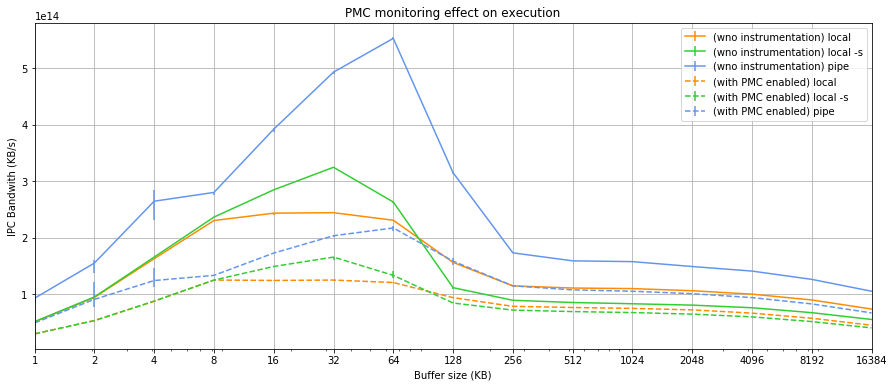

In [48]:
setup_dependencies()


modes = ["local", "local -s", "pipe"]
ax = plot_base()
for mode in modes:
    ax = plot_time(
        input_data_file="PMC_time_bench_{}-P mem.json".format(mode),
        label = "(with PMC enabled) "+mode,
        trials=10,
        axis = ax,
        title="PMC monitoring effect on execution",
        save_name = "pmc_execution_overhead.png" if mode == modes[-1] else None,
    )
